In [67]:
%matplotlib inline
import logging
import Euclid
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np

from matplotlib import colors
from astropy.table import Table, Column
from tqdm.notebook import tqdm
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from scikitplot.metrics import plot_confusion_matrix
from IPython.display import set_matplotlib_formats

%elogin
%erun SIM_Tools

from SimSpectra.SimSpectra import SimGalaxySpectra
from ST_DM_MDBTools.Mdb import Mdb

plt.rcParams['figure.figsize'] = (10, 6)
set_matplotlib_formats('pdf')

In [84]:
t = Table.read('/home/aalvarez/Work/Data/SC8/run5/pp_rerun_20210129_with_tu_SNR10.fits')

In [3]:
spec = SimGalaxySpectra(
    sedlib_filename='/home/aalvarez/Work/Data/SC8/TU/Lib/EUC-TEST-GSEDLIB-2015-03-18T171100.000.fits',
    filter_filename='/home/aalvarez/Work/Data/SC8/TU/Lib/EUC-TEST-FILSDSSR01-2015-02-02T203100.000.fits',
    extlib_filename='/home/aalvarez/Work/Data/SC8/TU/Lib/EUC-TEST-GEXTLAWLIB-2015-03-18T203100.000.fits',
    #extmap_filename=[
    #    '/home/aalvarez/Work/Data/SC8/TU/Lib/SFD_dust_1024_ngp.fits',
    #    '/home/aalvarez/Work/Data/SC8/TU/Lib/SFD_dust_1024_sgp.fits',
    #],
    extmap_filename=['/home/aalvarez/Work/Data/SC8/TU/Lib/HFI_CompMap_ThermalDustModel_2048_R1.20_V2.fits'],
    norm_sed='AB.sed',
    wmin=   500E-10,
    wmax=100000E-10,
    nwl=2000
)

INFO    : Use internal AB reference spectrum
2021-02-01T08:38:21CET SimSpectra  INFO : Use internal AB reference spectrum


In [4]:
def get_spectra(obj, sed_template):
    spectra = spec.get_spectra(
        ra=float(obj['RA_MAG']), dec=float(obj['DEC_MAG']), refmag=float(obj['REF_MAG']), absmag=float(obj['REF_MAG_ABS']),
        z=float(obj['Z_OBS']), ised=sed_template, ebv=float(obj['EBV']), extlaw=float(obj['EXT_LAW']), vacuum=True,
        lines={
            'halpha': float(obj['HALPHA_LOGFLAM_EXT_MAG']),
            'hbeta': float(obj['HBETA_LOGFLAM_EXT_MAG']),
            'O2': float(obj['O2_LOGFLAM_EXT_MAG']),
            'O3': float(obj['O3_LOGFLAM_EXT_MAG']),
            'N2': float(obj['N2_LOGFLAM_EXT_MAG']),
            'S2': float(obj['S2_LOGFLAM_EXT_MAG'])
        },
    )
    # Spectra is in Watts
    spectra *= 1e-7
    return np.stack([spec.wgrid.to(u.Angstrom).value, spectra], axis=-1)

Roughly

* From 0 to 8 elliptical
* From 9 to 19 spiral
* From 20 to 30 SB

In [85]:
t['GALTYPE'] = 0
t['GALTYPE'][(t['SED_TEMPLATE'] >= 9)] = 1
t['GALTYPE'][(t['SED_TEMPLATE'] > 19.5)] = 2
mask = t['FLAG']==0

In [86]:
t.colnames

['OBJECT_ID',
 'PHZ_PP_MEDIAN_Z',
 'PHZ_PP_MODE_Z',
 'PHZ_PP_68_Z',
 'PHZ_PP_MEDIAN_LOG_STELLARMASS',
 'PHZ_PP_MODE_LOG_STELLARMASS',
 'PHZ_PP_68_LOG_STELLARMASS',
 'PHZ_PP_MEDIAN_SFR',
 'PHZ_PP_MODE_SFR',
 'PHZ_PP_68_SFR',
 'GALAXY_CLASS',
 'PHZ_PP_SFH_TYPE',
 'PHZ_PP_SFH_TAU',
 'FLAG',
 'OBJECT_ID_1',
 'SOURCE_ID',
 'RA_MAG',
 'DEC_MAG',
 'Z_OBS',
 'REF_MAG_ABS',
 'REF_MAG',
 'KAPPA',
 'GAMMA1',
 'GAMMA2',
 'SED_TEMPLATE',
 'EXT_LAW',
 'EBV',
 'HALPHA_LOGFLAM_EXT_MAG',
 'HBETA_LOGFLAM_EXT_MAG',
 'O2_LOGFLAM_EXT_MAG',
 'O3_LOGFLAM_EXT_MAG',
 'N2_LOGFLAM_EXT_MAG',
 'S2_LOGFLAM_EXT_MAG',
 'AV',
 'GALTYPE']

In [79]:
labels = np.array(['Elliptical', 'Spiral', 'Starbust'])
plot_confusion_matrix(labels[t['GALTYPE'][mask]], labels[t['GALAXY_CLASS'][mask]], normalize=True)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

<Figure size 720x432 with 2 Axes>

In [80]:
def density_plot(a, b, ax=None):
    if not ax:
        ax = plt.gca()
    xy = np.vstack([a, b])
    density = gaussian_kde(xy)(xy)
    z_order = np.argsort(density)
    ax.scatter(a[z_order], b[z_order], c=density[z_order], cmap='jet', rasterized=True)

In [81]:
plt.figure()
density_plot(t[mask]['REF_MAG_ABS'], t[mask]['PHZ_PP_MODE_LOG_STELLARMASS'])
plt.xlabel('Reference Magnitude')
plt.ylabel('Log Stellarmass')
plt.show()

<Figure size 720x432 with 1 Axes>

In [82]:
a, b = np.polyfit(t[mask]['HALPHA_LOGFLAM_EXT_MAG'], t['PHZ_PP_MODE_SFR'][mask], 1)

In [83]:
plt.figure()
density_plot(t[mask]['HALPHA_LOGFLAM_EXT_MAG'], t['PHZ_PP_MODE_SFR'][mask])
plt.xlim(-18.5, -15)
plt.ylim(-5, 3)
plt.xlabel('H$\\alpha$')
plt.ylabel('SFR')
plt.show()

<Figure size 720x432 with 1 Axes>

In [429]:
sb_bad_0 = t[(t['GALTYPE'] == 2) & (t['GALAXY_CLASS'] == 0)]
sb_bad_1 = t[(t['GALTYPE'] == 2) & (t['GALAXY_CLASS'] == 1)]
sb_good = t[(t['GALTYPE'] == 2) & (t['GALAXY_CLASS'] == 2)]

In [485]:
def hist_mis(attr, ax=None):
    if ax is None:
        ax = plt.gca()
    bins = ax.hist(sb_bad_0[attr], histtype='step', label='Misclassified as elliptical', density=True)
    ax.hist(sb_bad_1[attr], histtype='step', label='Misclassified as spiral', bins=bins[1], density=True)
    ax.hist(sb_good[attr], histtype='step', label='Good', bins=bins[1], density=True)
    ax.set_xlabel(attr)
    ax.legend()

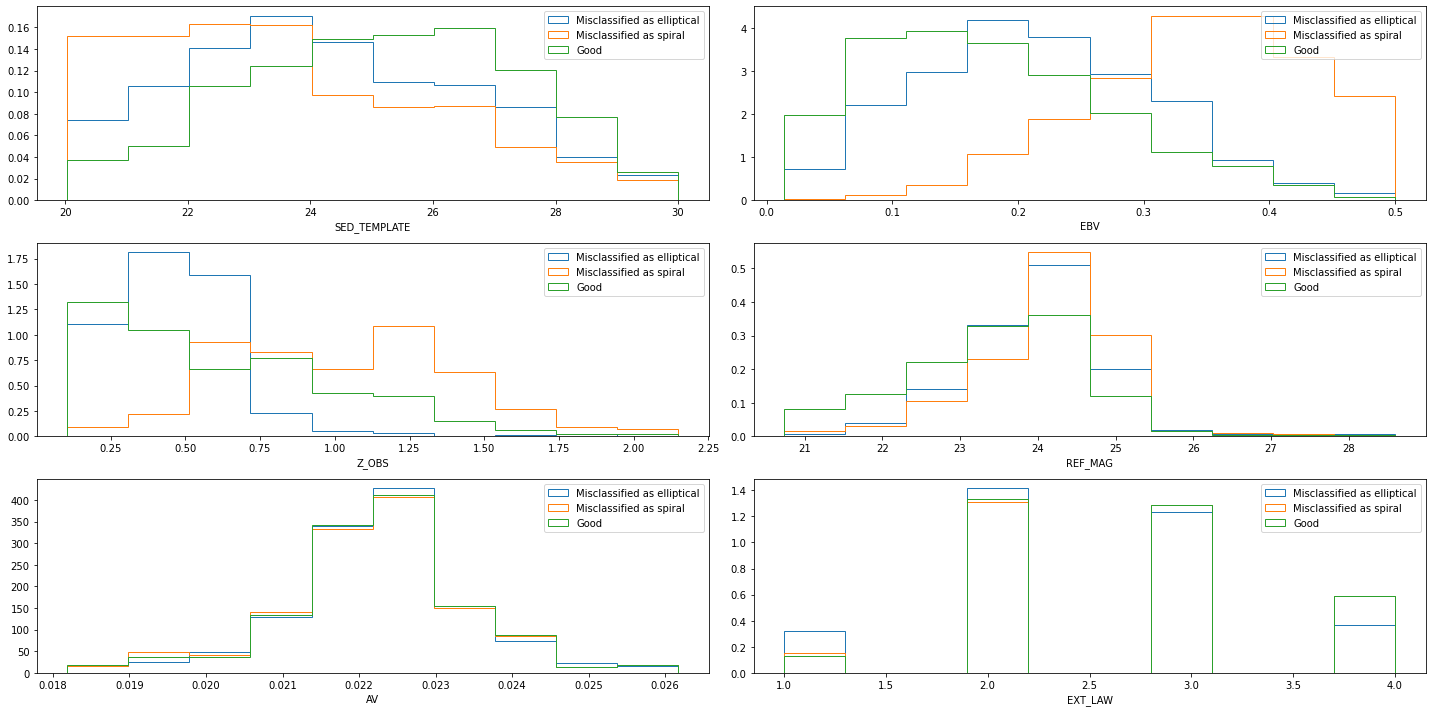

In [486]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 10))
for ax, attr in zip(axes.ravel(), ['SED_TEMPLATE', 'EBV', 'Z_OBS', 'REF_MAG', 'AV', 'EXT_LAW']):
    hist_mis(attr, ax)
plt.tight_layout()

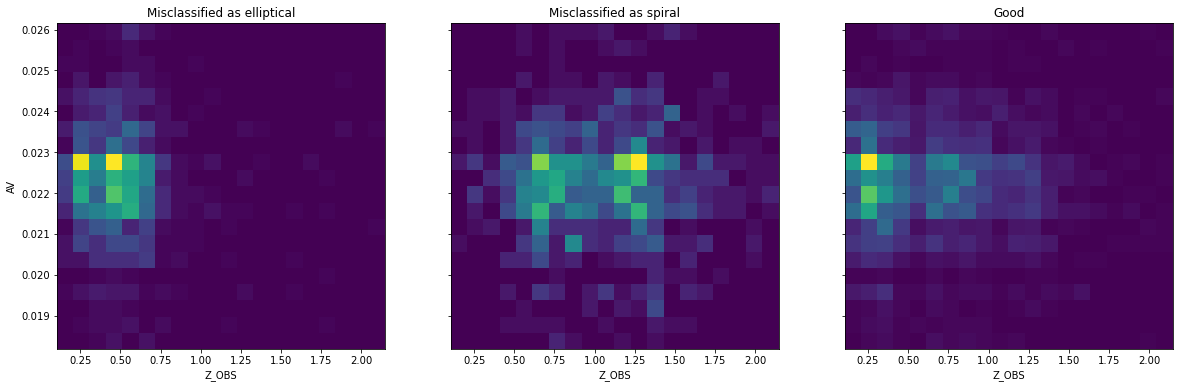

In [478]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 6))
bins = axes[0].hist2d(sb_bad_0['Z_OBS'], sb_bad_0['AV'], bins=20)
axes[0].set_title('Misclassified as elliptical')
axes[1].hist2d(sb_bad_1['Z_OBS'], sb_bad_1['AV'], bins=bins[1:3])
axes[1].set_title('Misclassified as spiral')
axes[2].hist2d(sb_good['Z_OBS'], sb_good['AV'], bins=bins[1:3])
axes[2].set_title('Good')

axes[0].set_ylabel('AV')
for ax in axes:
    ax.set_xlabel('Z_OBS')
plt.show()